# XAUUSD

In [1]:
import quandl
import pandas as pd
import numpy as np

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os

import warnings
import logging

# scikit-learn modules
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import cartesian

# User defined modules
from column_transformers.technical_indicators import MacdSignal, StochRsiSignal
from column_transformers.dates import DateDummy

In [2]:
xau_ratios = [
    "WGC/GOLD_DAILY_USD"
     #"WGC/GOLD_DAILY_EUR",
#     "WGC/GOLD_DAILY_TRY",
#     "WGC/GOLD_DAILY_JPY",
    #"WGC/GOLD_DAILY_GBP",
#     "WGC/GOLD_DAILY_CAD",
#     "WGC/GOLD_DAILY_CHF",
#     "WGC/GOLD_DAILY_VND",
#     "WGC/GOLD_DAILY_KRW",
#     "WGC/GOLD_DAILY_RUB",
#     "WGC/GOLD_DAILY_AUD",
]

economic_indc = []

### Quandl data terms

Anyone seeking to use this code must first apply for an account with [Quandl](https://www.quandl.com) in order to receive an valid authetitciation key.

In [3]:
DIR_NAME = os.path.abspath(os.path.join(os.getcwd(), '..'))
FILEPATH = os.path.join(DIR_NAME, "auth.txt")

with open(FILEPATH, "r") as f:
    authtoken = f.read();

# Retrieve Data

In [4]:
xau_df_dict = {}

for ratio in tqdm(xau_ratios):
    name = ratio.lower().replace("/", "_")

    # get the ratio dataframe
    df = quandl.get(ratio, authtoken=authtoken, start_date = "1979-01-01")
    df.columns = ["price"]
    
    # check for missing business days 
    if pd.infer_freq(df.index) != "B":
        logging.warn("Datetime frequency is not Business Days")
    
    xau_df_dict[name] = df

100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


## Volatility

In [5]:
annualization_factor = 252.
window_size = [5, 10, 20, 60, 120]

for ratio, df in tqdm(xau_df_dict.items()):
    start_date, end_date = df.index[0], df.index[-1]
    full_range = pd.date_range(start_date, end_date, freq = "B")
    
    if not np.array_equal(df.index, pd.date_range(start_date, end_date, freq="B")):
        logging.warning("\n{} is missing business days".format(ratio))

    for window in window_size:
        df['{}d_market_vol'.format(window)] = np.sqrt(
            (annualization_factor/window) * df['price'].rolling(window).var(ddof=0))

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


## Quandl Features

In [6]:
features = [
    "FRED/T10Y2Y",
    "RATEINF/INFLATION_USA",
]

In [7]:
for ratio, df in xau_df_dict.items():
    for feature in features:
        col_name = feature.lower().replace('/', '_')
        
        # get quandl features. `end_date` is set to df.index[-1] to match the price data
        data = quandl.get(feature, authtoken=authtoken, start_date = "1979-01-01", end_date = df.index[-1])
        start_date, end_date = data.index[0], data.index[-1]

        # Some features contain missing data. To best simulate how the data would be ingested
        # realtime, the current value is forward filled. This achieved by resampling.
        if not np.array_equal(data.index, pd.date_range(start_date, end_date, freq="B")):
            logging.warning("\n\t{} is missing business days".format(feature))
                    
        df[col_name] = data
    
    df[:] = df.ffill()

	FRED/T10Y2Y is missing business days
	RATEINF/INFLATION_USA is missing business days


## Technical indicator features

In [8]:
import talib

technical_indicators= {
    "MACD" : ("macd", "macdsignal", "macdhist"),
    "STOCHRSI" : ("fastk", "fastd"),
    "MOM" : ("real"),
    "APO" : ('real'),
    "RSI" : ('real')
}

for ratio, df in xau_df_dict.items():
    
    # talib requires market price data. starting price of $1 is taken
    # since absolute values are not important (preprocess scaling)
    price = df['price'].values

    for indicator, indicator_type in technical_indicators.items():
        # Return the result for each indicator
        if indicator == 'STOCHRSI':
            result = getattr(talib, indicator)(price, fastd_matype = 8)
        else:
            result = getattr(talib, indicator)(price)

        if isinstance(result, np.ndarray):
            df[indicator.lower()] = result
        else:
            for f, r in zip(indicator_type, result):
                if f == indicator.lower():
                    df["{}".format(indicator.lower())] = r
                else:
                    df["{}_{}".format(indicator.lower(), f)] = r

## Data preprocessing 

In [9]:
from split._split import TrainValidateTest

data = xau_df_dict['wgc_gold_daily_usd']
data['target'] = data['price'].shift(-1).pct_change()
data.dropna(inplace = True)

X = data.drop(['price', 'target'], axis = 1)
y = (data['target'] > 0).astype(int)
    
split = TrainValidateTest(0.7, 0.15, 0.15)
X_train, X_valid,  X_test, y_train, y_valid,  y_test = split.transform(X, y)

df = data.loc['1980':'1981', ['price', 'macd', 'macd_macdsignal']]

In [109]:
from column_transformers.alpha_factors import MacdStrategy

X = xau_df_dict['wgc_gold_daily_usd']['price'].copy()

s = MacdStrategy(result = 10)
s.fit(X)
s.optimal_parameters

  6%|▌         | 1/18 [00:00<00:03,  4.39it/s]/mnt/c/Users/Joseph Moorhouse/Google Drive/Joseph Moorhouse/EBB Holdings/Strategy_Analysis/02_xau/column_transformers/alpha_factors.py:193: RuntimeWarning: invalid value encountered in double_scalars
  return excess_return / strategy_returns.std()
100%|██████████| 18/18 [00:04<00:00,  4.81it/s]


array([[12.        , 29.        , 11.        ,  0.4605303 ],
       [15.        , 28.        ,  9.        ,  0.45362038],
       [16.        , 26.        ,  9.        ,  0.47024336],
       [10.        , 27.        , 14.        ,  0.45852835],
       [15.        , 27.        ,  9.        ,  0.45354897],
       [14.        , 27.        , 10.        ,  0.45352835],
       [18.        , 23.        ,  9.        ,  0.46195498],
       [10.        , 29.        , 13.        ,  0.46073757],
       [16.        , 25.        ,  9.        ,  0.45496066],
       [11.        , 29.        , 12.        ,  0.46426119]])

0

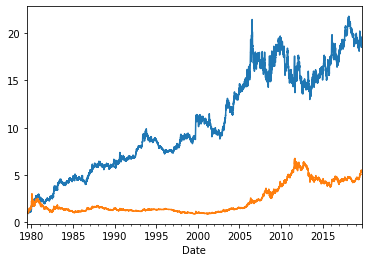

In [11]:
s = MacdStrategy(fast_period=16, slow_period=26, signal_period=9)
(1 + s.transform(X)['macd_strategy_returns'].dropna()).cumprod().plot()
(X/X[0]).plot()

s.optimal_parameters

In [20]:
from column_transformers.technical_indicators import StochasticRsi

class StochasticRsiStrategy(BaseEstimator, TransformerMixin):
    
    # ======================================================================
    # Constants
    # ======================================================================
    
    PRICE, FASTK, FASTD, RATIO = 0, 1, 2, 7
    
    # ======================================================================
    # Constructors
    # ======================================================================
    
    def __init__(self, 
                 criterion = 'sharpe',
                 optimal = True,
                 top_n = False,
                 length_min = 2,
                 stepsize = 20,
                 oversold_upper = 30,
                 oversold_lower = 10,
                 overbought_upper = 90,
                 overbought_lower = 50,
                 max_timeperiod = 20,
                 max_fastk = 10,
                 max_fastd = 10):
    
        self.criterion = criterion
        
        if optimal and top_n:
            raise ValueError("Both 'optimal' and 'top_n' were detected." 
                             "Choose either 'optimal' or 'top_n'.")
        elif not optimal and not top_n:
            raise ValueError("Please specify either 'optimal' or 'top_n'.")
        
        self.optimal = optimal
        
        if optimal:
            self.ratio = 0
            
        self.top_n = top_n
        
        if top_n:
            if isinstance(top_n, (int, float)):
                self.top_n_strategies = np.zeros([top_n, 8])
            else:
                raise TypeError("'top_n must be of type 'int")
                     
        self.parameter_grid = self._parameter_grid(
            length_min,
            stepsize,
            oversold_upper,
            oversold_lower, 
            overbought_upper, 
            overbought_lower, 
            max_timeperiod, 
            max_fastk,
            max_fastd
        )
        
    def _parameter_grid(self, 
                        length_min,
                        stepsize,
                        oversold_upper,
                        oversold_lower, 
                        overbought_upper, 
                        overbought_lower, 
                        max_timeperiod, 
                        max_fastk, 
                        max_fastd):
        
        # StochasticRsi() parameters
        timeperiod, fastk, fastd = (
            range(length_min, max_timeperiod), 
            range(length_min, max_fastk),
            range(length_min, max_fastd)
        )
            
        # Strategy paramters
        long_entry, long_exit, short_entry, short_exit = (
            range(oversold_lower, oversold_upper, stepsize),
            range(overbought_lower, overbought_upper, stepsize),
            range(overbought_lower, overbought_upper, stepsize),
            range(oversold_lower, oversold_upper, stepsize)
        )
            
        return cartesian([
            timeperiod, 
            fastk, 
            fastd, 
            long_entry,
            long_exit,
            short_entry,
            short_exit
        ])
        
        

    def _indicator(self, X, timeperiod, fastk, fastd):
        ind = StochasticRsi(timeperiod, fastk, fastd)
        
        return ind.fit_transform(X)
    
    
    def _long_signal(self, indicator, long_entry, long_exit):
        
        # Use np.insert if shift is greater than 1
        signal_entry = indicator[:, self.FASTK] > long_entry
        signal_hold = indicator[:, self.FASTK] > long_exit
        
        # Define the long signal
        long = signal_entry | signal_hold
        
        return long[:-1] * 1
    
    
    def _short_signal(self, indicator, short_entry, short_exit):
        
        #Use np.insert if shift is greater than 1
        signal_entry = indicator[:, self.FASTK] < short_entry
        signal_hold = indicator[:, self.FASTK] < short_exit
        
        # Define the long signal
        short = signal_entry | signal_hold
        
        return short[:-1] * -1
    
    
    def _asset_returns(self, indicator):
        return (
            np.diff(indicator[:, self.PRICE]) / indicator[:-1, self.PRICE]
        )
    
    def _strategy_returns(self, 
                          indicator, 
                          long_entry, 
                          long_exit, 
                          short_entry, 
                          short_exit):
        
        # generate strategy long/short signal and asset returns
        long_signal = self._long_signal(indicator, long_entry, long_exit)
        short_signal = self._short_signal(indicator, short_entry, short_exit)
        
        # calculate the assets simple returns 
        asset_returns = self._asset_returns(indicator)
        
        return (asset_returns * long_signal) + (asset_returns * short_signal)
        
        
    def _criterion(self, 
                   strategy_returns, 
                   annualisation_factor, 
                   risk_free_rate):
        
        excess_return = strategy_returns.mean() - risk_free_rate
        
        return np.sqrt(annualisation_factor) * excess_return / strategy_returns.std()
        
        
    def _fit(self, X, y, annualisation_factor, risk_free_rate):
   
        for params in tqdm(self.parameter_grid):
            t, k, d, l_en, l_ex, s_en, s_ex = params
                
            indicator = self._indicator(X, t, k, d)
            strategy_returns = self._strategy_returns(
                indicator, l_en, l_ex, s_en, s_ex
            )

            ratio = self._criterion(
                    strategy_returns, annualisation_factor, risk_free_rate
            )

            if self.optimal:
                if ratio > self.ratio:
                    self.ratio = ratio
                    self.parameters =  np.array([t, k, d, l_en, l_ex, s_en, s_ex])
            else:
                argmin = self.top_n_strategies[:, self.RATIO].argmin()
                
                if ratio > self.top_n_strategies[argmin, self.RATIO]:
                    self.top_n_strategies[argmin] = [
                        t, k, d, l_en, l_ex, s_en, s_ex, ratio
                    ]  
        
        
    def fit(self, X, y=None, annualisation_factor=252, risk_free_rate=0.00):
        
        self._fit(X, y, annualisation_factor, risk_free_rate)
        return self
    
    
    def transform(self, X, y=None, n=None):
        
        if self.top_n:
            if isinstance(n, int):
                t, k, d = self.top_n_strategies[n, :3]
                l_en, l_ex, s_en, s_ex = self.top_n_strategies[n, 3:self.RATIO]
            else:
                raise ValueError("'n = {}' is invalid. Please specify number" 
                                 "between 0 and {}".format(
                                     n, self.top_n_strategies.shape[0] - 1)
                                )
        else:
            if n is not None:
                raise ValueError("'n = {}' is invalid. 'optimal' strategy" 
                                 "paramters only. 'n' must be NoneType".format(n))
                
            t, k, d = self.parameters[:3]
            l_en, l_ex, s_en, s_ex = self.parameters[3:] 
              
        indicator = self._indicator(X, t, k, d)
        strategy_returns = self._strategy_returns(
            indicator, l_en, l_ex, s_en, s_ex
        )
        
        return np.c_[indicator[1:], strategy_returns]
        
x = X        
ind = StochasticRsiStrategy(max_timeperiod=25)
ind.fit(x)

  0%|          | 0/5888 [00:00<?, ?it/s]/mnt/c/Users/Joseph Moorhouse/Google Drive/Joseph Moorhouse/EBB Holdings/Strategy_Analysis/02_xau/column_transformers/technical_indicators.py:34: RuntimeWarning: divide by zero encountered in true_divide
  real = ((rsi - min_rsi) / (max_rsi - min_rsi)) * 100,
/mnt/c/Users/Joseph Moorhouse/Google Drive/Joseph Moorhouse/EBB Holdings/Strategy_Analysis/02_xau/column_transformers/technical_indicators.py:34: RuntimeWarning: invalid value encountered in true_divide
  real = ((rsi - min_rsi) / (max_rsi - min_rsi)) * 100,
100%|██████████| 5888/5888 [00:08<00:00, 695.16it/s]


StochasticRsiStrategy(criterion='sharpe', length_min=None, max_fastd=None,
                      max_fastk=None, max_timeperiod=None, optimal=True,
                      overbought_lower=None, overbought_upper=None,
                      oversold_lower=None, oversold_upper=None, stepsize=None,
                      top_n=False)

array([19,  3,  2, 10, 50, 50, 10])

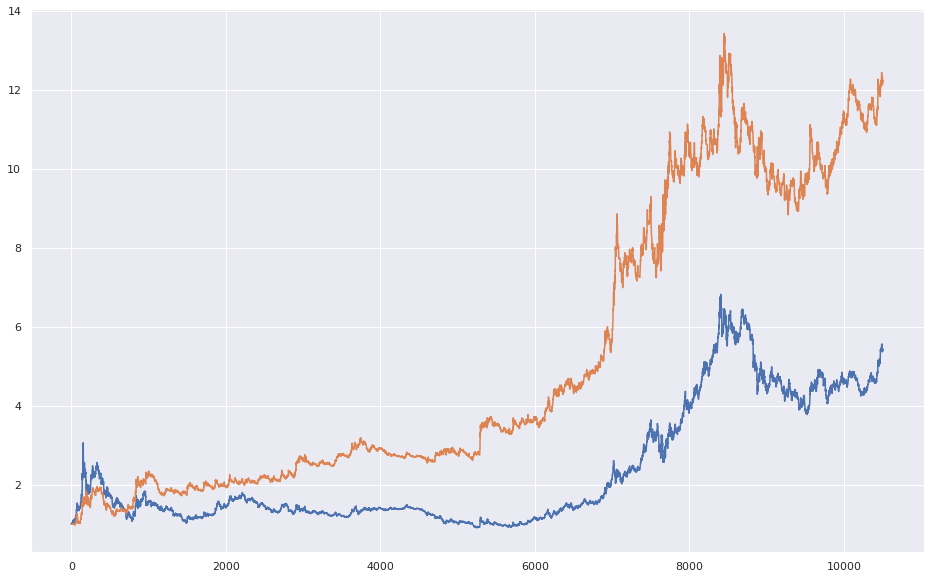

In [23]:
plt.plot(((ind.transform(x)[:, 0]/ind.transform(x)[0, 0])))
plt.plot(((1 + ind.transform(x)[:, 3]).cumprod()))

ind.ratio
ind.parameters

In [110]:
from abc import ABC, abstractmethod

class BaseIndicator(ABC, BaseEstimator):
    
    @abstractmethod
    def __init__(self, 
                 criterion, 
                 optimal, 
                 top_n, 
                 length_min,
                 stepsize):
        
        self.criterion = criterion
        self.optimal = optimal
        self.top_n = top_n
        self.length_min = length_min
        self.stepsize = stepsize
        
    # ======================================================================
    # User implemented methods
    # ======================================================================    
    
    @abstractmethod
    def _price_indicator(self, **kwargs):
        pass
    
    
    
class BaseStrategy(BaseIndicator, TransformerMixin):
    
    # ======================================================================
    # Constants
    # ======================================================================
    
    
    # ======================================================================
    # Constructors
    # ======================================================================
    
    @abstractmethod
    def __init__(self, 
                 criterion, 
                 optimal, 
                 top_n, 
                 length_min,
                 stepsize,
                 annualisation_factor,
                 risk_free_rate,
                 **kwargs):
        
        self.criterion = criterion
        
        if optimal and top_n:
            raise ValueError("Both 'optimal' and 'top_n' were detected." 
                             "Choose either 'optimal' or 'top_n'.")
        elif not optimal and not top_n:
            raise ValueError("Please specify either 'optimal' or 'top_n'.")
        
        self.optimal = optimal
        
        if optimal:
            self.ratio = 0
            
        self.top_n = top_n
        
        if top_n:
            if isinstance(top_n, (int, float)):
                self.top_n_strategies = np.zeros([top_n, 8])
            else:
                raise TypeError("'top_n must be of type 'int")

        self.length_min = length_min
        self.stepsize = stepsize 
        self.annualisation_factor = annualisation_factor
        self.risk_free_rate = risk_free_rate
    
    # ======================================================================
    # User implemented methods
    # ======================================================================
    
    def _indicator_params(self, indicator_params):
        for param_name, param in self.indicator_params.items():
            param_range = range(self.length_min, param + 1)
            yield param_range
        
        
    def _overbought_region(self, overbought_upper, overbought_lower):
        short_entry = long_exit = range(
            overbought_lower, overbought_upper, self.stepsize)

        return short_entry, long_exit

    
    def _oversold_region(self, oversold_upper, oversold_lower):
        long_entry = short_exit = range(
            oversold_lower, oversold_upper, self.stepsize)

        return long_entry, short_exit

    
    def _parameter_grid(self):
        params = list(self._indicator_params(self.indicator_params))

        try:
            long_entry, short_exit = self._oversold_region(
                self.oversold_upper, 
                self.oversold_lower)

            short_entry, long_exit = self._overbought_region(
                self.overbought_upper, 
                self.overbought_lower)

            params = params + [
                long_entry, long_exit, short_entry, short_exit
            ]
        except AttributeError:
            warnings.warn ("No buy or sell regions are set")

        return cartesian(params)
    
    @abstractmethod
    def _long_signal(self, price_indicator, **kwargs):
        pass
    
    @abstractmethod
    def _short_signal(self, price_indicator, **kwargs):
        pass
    
    # ======================================================================
    # Strategy methods
    # ======================================================================
    
    def _asset_returns(self, price_indicator):
        return (np.diff(
            price_indicator[:, self.PRICE]) / 
            price_indicator[:-1, self.PRICE]
        )
    
    def _strategy_returns(self,
                          price_indicator=None, 
                          long_entry=None, 
                          long_exit=None, 
                          short_entry=None, 
                          short_exit=None):
        
        # generate strategy long/short signal and asset returns
        long_signal = self._long_signal(price_indicator)
        short_signal = self._short_signal(price_indicator)
        
        # calculate the assets simple returns 
        asset_returns = self._asset_returns(price_indicator)
        
        return (asset_returns*long_signal) + (asset_returns*short_signal)
    
    
    def _criterion(self, 
                   strategy_returns, 
                   annualisation_factor, 
                   risk_free_rate):
        
        excess_return = strategy_returns.mean() - risk_free_rate
        
        return np.sqrt(annualisation_factor) * excess_return / strategy_returns.std()
    
    
    def fit(self, X, y=None):
   
        for params in tqdm(self.parameter_grid):
            t, k, d = params#, l_en, l_ex, s_en, s_ex = params
                
            price_indicator = self._price_indicator(X, t, k, d)
            strategy_returns = self._strategy_returns(
                price_indicator)#, l_en, l_ex, s_en, s_ex
            #)

            ratio = self._criterion(
                    strategy_returns, self.annualisation_factor, self.risk_free_rate
            )

            if self.optimal:
                if ratio > self.ratio:
                    self.ratio = ratio
                    self.parameters =  np.array([t, k, d])#, l_en, l_ex, s_en, s_ex])
            else:
                argmin = self.top_n_strategies[:, self.RATIO].argmin()
                
                if ratio > self.top_n_strategies[argmin, self.RATIO]:
                    self.top_n_strategies[argmin] = [
                        t, k, d, l_en, l_ex, s_en, s_ex, ratio
                    ] 
                    
        return self
    
    
    def transform(self, X, y=None, n=None):
        
        if self.top_n:
            if isinstance(n, int):
                t, k, d = self.top_n_strategies[n, :3]
                l_en, l_ex, s_en, s_ex = self.top_n_strategies[n, 3:self.RATIO]
            else:
                raise ValueError("'n = {}' is invalid. Please specify number" 
                                 "between 0 and {}".format(
                                     n, self.top_n_strategies.shape[0] - 1)
                                )
        else:
            if n is not None:
                raise ValueError("'n = {}' is invalid. 'optimal' strategy" 
                                 "paramters only. 'n' must be NoneType".format(n))
                
            t, k, d = self.parameters[:3]
            #l_en, l_ex, s_en, s_ex = self.parameters[3:] 
              
        price_indicator = self._price_indicator(X, t, k, d)
        strategy_returns = self._strategy_returns(
            price_indicator)#, l_en, l_ex, s_en, s_ex
        #)
        
        return np.c_[price_indicator[1:], strategy_returns]
        
        
class StochasticRsiStrategy(BaseStrategy):
    
    # ======================================================================
    # Constants
    # ======================================================================
    
    PRICE, FASTK, FASTD, RATIO = 0, 1, 2, 7
    
    def __init__(self,
                 criterion = 'sharpe',
                 optimal = True,
                 top_n = False,
                 length_min = 2,
                 stepsize = 10,
                 annualisation_factor = 252,
                 risk_free_rate = 0.00,
                 oversold_upper = 30,
                 oversold_lower = 10,
                 overbought_upper = 90,
                 overbought_lower = 50,
                 indicator_params = {}):
        
        
        super().__init__(criterion = criterion,
                         optimal = optimal,
                         top_n = top_n,
                         length_min = length_min,
                         stepsize = stepsize,
                         annualisation_factor = annualisation_factor ,
                         risk_free_rate = risk_free_rate)
        
        self.oversold_upper = oversold_upper
        self.oversold_lower = oversold_lower
        self.overbought_upper = overbought_upper
        self.overbought_lower = overbought_lower
        self.indicator_params = indicator_params
        self.parameter_grid = super()._parameter_grid()
        
        #reorganise this
        self.ratio = 0


    def _price_indicator(self, X, timeperiod, fastk, fastd):
        ind = StochasticRsi(timeperiod, fastk, fastd)
        
        return ind.fit_transform(X)
        
    def _long_signal(self, price_indicator, long_entry, long_exit):
        
        # Use np.insert if shift is greater than 1
        signal_entry = price_indicator[:, self.FASTK] > long_entry
        signal_hold = price_indicator[:, self.FASTK] > long_exit
        
        # Define the long signal
        long = signal_entry | signal_hold
        
        return long[:-1] * 1
    
    
    def _short_signal(self, price_indicator, short_entry, short_exit):
        
        #Use np.insert if shift is greater than 1
        signal_entry = price_indicator[:, self.FASTK] < short_entry
        signal_hold = price_indicator[:, self.FASTK] <= short_exit
        
        # Define the long signal
        short = signal_entry | signal_hold
        
        return short[:-1] * -1    
        
params = {"indicator_params" : dict(time_period = 25, fastk = 5, fastd=5),
          "overbought_lower":40,
          "overbought_upper":70,
          "oversold_lower":0,
          "oversold_upper" :20,
          "stepsize": 10,
          "top_n" : 50,
          "optimal" : False}



class MacdStrategy(BaseStrategy):
    
    PRICE, MACD, MACD_SIGNAL, MACD_HIST, RATIO = 0, 1, 2, 3, 3
    
    def __init__(self,
                 criterion = 'sharpe',
                 optimal = True,
                 top_n = False,
                 length_min = 2,
                 stepsize = None,
                 annualisation_factor = 252,
                 risk_free_rate = 0.00,
                 indicator_params = {}):
        
        super().__init__(criterion = criterion,
                         optimal = optimal,
                         top_n = top_n,
                         length_min = length_min,
                         stepsize = stepsize,
                         annualisation_factor = annualisation_factor ,
                         risk_free_rate = risk_free_rate)

        self.indicator_params = indicator_params
        self.parameter_grid = super()._parameter_grid()
        
    
    def _price_indicator(self, X, fast_period, slow_period, signal_period):
        
        macd_statistics = talib.MACD(
            X,
            fastperiod = fast_period,
            slowperiod = slow_period,
            signalperiod = signal_period
        )   
        
        return np.c_[X, np.array(macd_statistics).T]
    
    def _long_signal(self, price_indicator):
        long = price_indicator[:, self.MACD] > price_indicator[:, self.MACD_SIGNAL]
        
        return long[:-1] * 1
    
    
    def _short_signal(self, price_indicator):
        short = price_indicator[:, self.MACD] < price_indicator[:, self.MACD_SIGNAL]
       
        return short[:-1] * -1
    
params = {"indicator_params" :  dict(fast_period =10, slow_period = 40, signal_period_test = 15)} 
ind = MacdStrategy(**params)
g = ind.fit_transform(x)

/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: No buy or sell regions are set
  0%|          | 0/4914 [00:00<?, ?it/s]/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:341: RuntimeWarning: invalid value encountered in greater
/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:347: RuntimeWarning: invalid value encountered in less
/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 4914/4914 [00:37<00:00, 130.98it/s]


/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:341: RuntimeWarning: invalid value encountered in greater
/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:347: RuntimeWarning: invalid value encountered in less


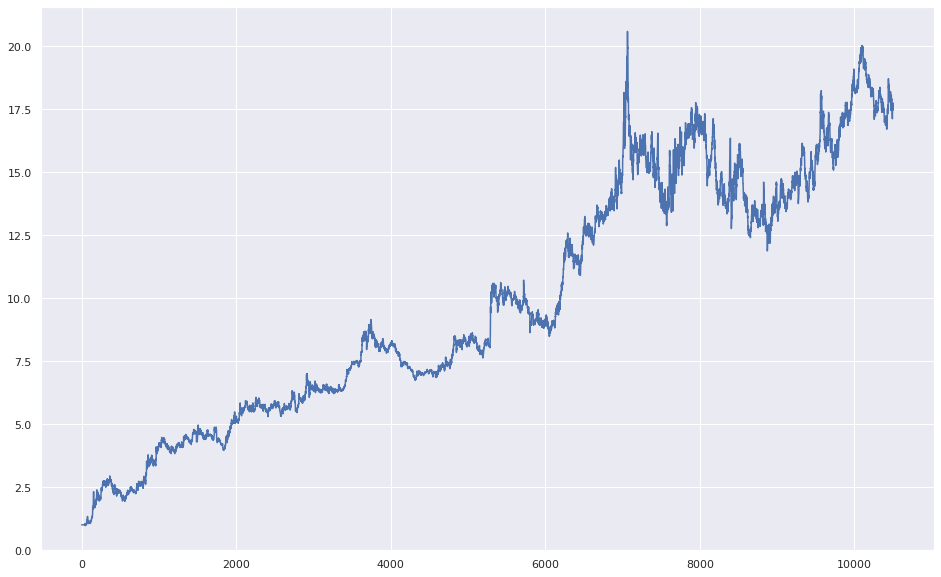

In [121]:
returns = g[:, 3]
returns = returns[~np.isnan(returns)]

pi = ind._price_indicator(x, 10, 29, 13)
plt.plot((1 + ind._strategy_returns(pi)).cumprod())

In [117]:
sns.set(rc={'figure.figsize':(16, 10)})


#plt.plot((g[:, 0]/ g[:, 0][0]))
ind.parameters

array([10, 29, 13])

In [30]:
longs = X_rsi.index[X_rsi['long'] == 1]
shorts = X_rsi.index[X_rsi['short'] == -1]

# start date positions of new long/short positions
long_indices_or_sections = np.arange(longs.size)[longs.to_series().diff() > pd.Timedelta('3D')]
short_indices_or_sections = np.arange(shorts.size)[shorts.to_series().diff() > pd.Timedelta('3D')]

long_date_regions = np.split(longs, long_indices_or_sections)
short_date_regions = np.split(shorts, short_indices_or_sections)

pd.DataFrame(trans, index=x.index[1:], columns = ['price', 'fastk', 'fatsd', 'returns'])


,price,fastk,fatsd,returns
Date,,,,
1979-07-11,290.30,NaN,NaN,-0.000000
1979-07-12,290.75,NaN,NaN,0.000000
1979-07-13,287.45,NaN,NaN,-0.000000
1979-07-16,292.80,NaN,NaN,0.000000
1979-07-17,296.30,NaN,NaN,0.000000
1979-07-18,302.15,NaN,NaN,0.000000
1979-07-19,299.15,NaN,NaN,-0.000000
1979-07-20,298.75,NaN,NaN,-0.000000
1979-07-23,304.90,NaN,NaN,0.000000


In [ ]:
df = data.loc[:, ['price', 'macd', 'macd_macdsignal']]

# Calculate the returns
df['returns'] = df['price'].pct_change()

# long/short periods ignoring lookahead bias
long_biased = df['macd'] >= df['macd_macdsignal']
short_biased = (df['macd'] <= df['macd_macdsignal'])

# Define long entry and exit points
long_entry = (df['macd'].shift(1) > df['macd_macdsignal'].shift(1)) #& (df['macd'].diff() > 0 & (df['macd'].diff().shift(1) < 0))
#cross_over_long_exit = (df['macd'] < df['macd_macdsignal']) & (df['macd'].shift(1) > df['macd_macdsignal'].shift(1))
#omentum_long_exit = (df['macd'].diff() >= 0) & (df['macd'].diff().shift(1) <= 0)

# Define short entry and exit points
short_entry = (df['macd'].shift(1) < df['macd_macdsignal'].shift(1)) & ((df['macd'].diff().shift(1) < 0))
#cross_over_short_exit = (df['macd'] > df['macd_macdsignal']) & (df['macd'].shift(1) < df['macd_macdsignal'].shift(1))
#momentum_short_exit = (df['macd'].diff() <= 0) & (df['macd'].diff().shift(1) <= 0)

# define simple long/short strategy
df['long'] = (long_entry) * 1 # add exit periods back here
df['short'] = (short_entry) * -1

# long/short periods
longs = df.index[df['long'] == 1]
shorts = df.index[df['short'] == -1]

# start date positions of new long/short positions
long_indices_or_sections = np.arange(longs.size)[longs.to_series().diff() > pd.Timedelta('3D')]
short_indices_or_sections = np.arange(shorts.size)[shorts.to_series().diff() > pd.Timedelta('3D')]

# long/short date regions
long_date_regions = np.split(longs, long_indices_or_sections)
short_date_regions = np.split(shorts, short_indices_or_sections)


df['alpha_return'] = (df['returns'] * df['long']) + (df['returns'] * df['short']) 
df['gold_perf'] =  (1 + df['returns']).cumprod()
df['alpha_perf'] = (1 + df['alpha_return']).cumprod()

#df = df.dropna()

print((np.sqrt(252.) * df['alpha_return'].mean()) / df['alpha_return'].std())

df[['alpha_perf', 'gold_perf']].plot()

In [ ]:
d = d.dropna()

In [ ]:
d.head()

In [ ]:
sns.set(rc={'figure.figsize':(16, 10)})
fig, axes = plt.subplots(nrows=3, ncols=1)

df.loc['1990', 'alpha_perf'].plot(ax = axes[0])
df.loc['1990', ['macd', 'macd_macdsignal']].plot(ax=axes[1])
df.loc['1990', 'gold_perf'].plot(ax = axes[2])

for l_period, s_period in zip(long_date_regions, short_date_regions):
    for ax in axes:
        ax.axvline(l_period[0], color='green', linewidth=1)
        ax.axvline(s_period[0], color='green', linewidth=1)
                                             
        ax.axvline(l_period[-1], color='red', linewidth=1)
        ax.axvline(s_period[-1], color='red', linewidth=1)

        ax.axvspan(l_period[0], l_period[-1], alpha = 0.1, color = 'green')
        ax.axvspan(s_period[0], s_period[-1], alpha = 0.1, color = 'red')

In [ ]:
preprocess_pipeline = Pipeline([
     ('macd_ud_signal', MacdSignal()),
     ('stoch_ud_signal', StochRsiSignal()),
     #('date', DateDummy('weekday_name', 'month_name')),
     #('vol_diff', VolatilityDiff()),
     #('scalar', StandardScaler())
])

X_train_trans, X_valid_trans= (
    preprocess_pipeline.fit_transform(X_train),
    preprocess_pipeline.transform(X_valid)
)

X_train_trans.head()

In [ ]:
sns.set(rc={'figure.figsize':(15, 8)})
df = X_train.loc['1981', ['10d_market_vol', '20d_market_vol']]

d_20 = df['10d_market_vol']
d_60 = df['20d_market_vol']

df.plot()

dates = (
    (d_20 > d_60) & (d_20.shift(-1) < d_60.shift(-1)) |
    (d_20 > d_60) & (d_20.shift(1) < d_60.shift(1))
)

for date in d_20.index[dates]:
    plt.axvline(date)
    difference = (d_20 -d_60)

difference.index[(difference < 0) & (difference.shift(-1) > 0)]
difference.plot()

xau_df_dict['wgc_gold_daily_usd'].loc['1981', 'price'].plot()
for date in d_20.index[dates]:
    plt.axvline(date)

## Model Selection

In [ ]:

classifiers = [
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100),
]

In [ ]:
results = {}

for clf in tqdm(classifiers, unit='Model') :
    clf.fit(X_train_trans, y_train)
    
    name = str(clf).split('(')[0]
    
    results[name] = {
        "train_score" : clf.score(X_train_trans, y_train),  
        "valid_score" : clf.score(X_valid_trans, y_valid)
    }      
    
results

## Model Evaluation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits = 2)
clf =  RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0)
rf_param_grid = {
    'max_depth': [25, 30],
    'min_samples_leaf': [10, 15, 16],
    'min_samples_split': [2, 5],
    'n_estimators': [50, 100, 150]
}

search = GridSearchCV(estimator=clf, cv=tscv, param_grid=rf_param_grid)
search.fit(X_train_trans, y_train)

In [ ]:
search.score(X_train_trans, y_train), search.score(X_valid_trans, y_valid)
search.best_params_

In [ ]:
train_score

In [ ]:
n_days = X_train.shape[0]
n_features = X_train.shape[1]

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 15,
    'max_depth' : 25,
     'min_samples_split': 8,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [75, 100, 150, 300]

In [ ]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    
    clf = RandomForestClassifier(**search.best_params_)
    clf.fit(X_train_trans, y_train)
    
    train_score.append(clf.score(X_train_trans, y_train))
    valid_score.append(clf.score(X_valid_trans, y_valid))
    
#     oob_score.append(clf.oob_score_)
#     feature_importances.append(clf.feature_importances_)

In [ ]:
train_score, valid_score


In [ ]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.3, 0.9))
        plt.plot(x, y, label=label)
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

plot([n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
prob_array=[-1,1]
alpha_score = clf.predict_proba(X_train_trans).dot(np.array(prob_array))

# calculate daily returns
alpha_return = alpha_score * data.loc[X_train.index, 'target'].shift(-1) 

xau_usd_return = data.loc[X_train.index, 'target']

# calculate cumulative performance
alpha_perf = 100000 * ((1 + alpha_return).cumprod())
xau_usd_per = 100000 * ((1 + xau_usd_return).cumprod())

#alpha_return.plot()
alpha_sharpe = (np.sqrt(252.) * alpha_return.mean()) / alpha_return.std() 
xau_usd_sharpe = (np.sqrt(252.) * xau_usd_return.mean()) / xau_usd_return.std() 

alpha_perf.plot()
xau_usd_per.plot()

xau_usd_return.mean() / alpha_return.mean() 
sns.set(rc={'figure.figsize':(15, 8)})
plt.legend(labels = ['Model', 'Actual Gold/USD'])


print(alpha_sharpe, xau_usd_sharpe)
alpha_return.std() / xau_usd_return.std()

alpha_perf[-2] ** (252 / alpha_perf.size) - 1 

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes=np.linspace(.1, 1.0, 5)
estimator = RandomForestClassifier(**search.best_params_)
cv = TimeSeriesSplit(n_splits = 5)


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(estimator, "lol", X, y, n_jobs =4, cv =cv, train_sizes=train_sizes)

In [ ]:
#learning_curve(
        #estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    
cv